In [1]:
%matplotlib inline
import numpy as np
import json
import seaborn as sns
import pandas as pd
import os
import glob
import SimpleITK as itk
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
sns.set_style("whitegrid")
from src.utils import save_json, subfiles, join, maybe_mkdir_p, reconstruct_seg_df_from_json, reconstruct_calib_df_from_json, reconstruct_UED_df_from_json



# compare between different group using UED, FND, FPD

In [2]:
## directorys for main internal probability maps 

NNUNET_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
DROP1_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout1__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
DROP2_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
DROP3_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout3__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
DROP5_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout5__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"

PHISEG_UREGIONS = "/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
PHISEG_GAMMA_UREGIONS= "/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"

studies = [
join(NNUNET_UREGIONS,'f0'),
join(NNUNET_UREGIONS,'f0_tta'),
join(DROP2_UREGIONS,'f0_mc10_tta')
,join(NNUNET_UREGIONS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_UREGIONS,'f0_tta_snap')
,join(DROP2_UREGIONS,'f01234_mc10_tta_snap')
,join(PHISEG_UREGIONS,'f01234_tta')

]
#,join(PH_GAMM_PMAP,'f0_tta')]

def compute_best_ued(studies):
    groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots',"Complex", 'PhiSeg' ]

    # Define the base directory

    for index, group in enumerate(groups):

        base_dir = studies[index]

        # Define the subdirectories to iterate through
        #subdirs = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] #best th leads to results without 
        subdirs = ["7"]
        # Initialize a dictionary to store the results for each patient

        results = [] 
        # Iterate through the subdirectories
        for gtv in ['GTV-T', 'GTV-N']:
            patient_results = {}
            for subdir in subdirs:
                # Obtain the UED summary.json file path
                ued_path = os.path.join(base_dir, subdir, gtv+"_union", "summary.json")
                # Obtain the FND and FPD summary.json file path
                
                fpnd_path = os.path.join(base_dir, subdir, gtv, "summary.json")
                # Check if the summary.json files exist
                if os.path.exists(ued_path) and os.path.exists(fpnd_path):
                    # Read the UED summary.json file
                    with open(ued_path) as f:
                        ued_data = json.load(f)
                    # Read the FND and FPD summary.json file
                    with open(fpnd_path) as f:
                        fpnd_data = json.load(f)

                    # Iterate through the patients in the UED summary.json file
                    for patient_data in ued_data["results"]["all"]:
                        # Obtain the unique patient ID
                        patient_id = os.path.basename(patient_data["reference"]).split(".nii.gz")[0]
                        # Check if the patient ID already exists in the patient_results dictionary
                        if patient_id not in patient_results:
                            # Create a new dictionary for the patient ID
                            patient_results[patient_id] = {}
                        # Obtain the UED value for the patient
                        ued_value = patient_data["1"]["Dice"]
                        ued_volume = patient_data["1"]["Total Positives Test"]

                        # Check if the UED value is higher than the current value for the patient
                        if "UED" not in patient_results[patient_id]:
                            # Add the UED value to the patient's dictionary
                            patient_results[patient_id]["UED"]= ued_value
                            patient_results[patient_id]["UED_volume"]= ued_volume

                            patient_results[patient_id]["UED_th"]= subdir
                        if ued_value > patient_results[patient_id]["UED"]:
                            # Add the UED value to the patient's dictionary
                            patient_results[patient_id]["UED"] = ued_value
                            patient_results[patient_id]["UED_volume"]= ued_volume
                            patient_results[patient_id]["UED_th"] = subdir
                        if ued_volume == 0:
                            patient_results[patient_id]["UED"]= np.nan
                            patient_results[patient_id]["UED_volume"]= ued_volume
                            patient_results[patient_id]["UED_th"]= 0

                    for patient_data in fpnd_data["results"]["all"]:
                        # Obtain the unique patient ID
                        patient_id = os.path.basename(patient_data["reference"]).split(".nii.gz")[0]
                        if patient_id not in patient_results:
                            print("fError, some thing went wrong {patient_id}")
                            # Create a new dictionary for the patient ID
                            break
                        # Obtain the FND value for the patient
                        fnd_value = patient_data["1"]["Dice"]
                        fnd_volume = patient_data["1"]["Total Positives Test"]
                        # Obtain the FPD value for the patient
                        fpd_value = patient_data["2"]["Dice"]
                        fpd_volume = patient_data["2"]["Total Positives Test"]

                        # Check if the FND value is higher than the current value for the patient
                        if "FND" not in patient_results[patient_id]:
                            # Add the FND value to the patient's dictionary
                            patient_results[patient_id]["FND"] = fnd_value
                            patient_results[patient_id]["FND_volume"]= fnd_volume
                            patient_results[patient_id]["FND_th"] = subdir
                        if fnd_value > patient_results[patient_id]["FND"]:
                            # Add the FND value to the patient's dictionary
                            patient_results[patient_id]["FND"]= fnd_value
                            patient_results[patient_id]["FND_volume"]= fnd_volume
                            patient_results[patient_id]["FND_th"] = subdir
                        if fnd_volume == 0:
                            patient_results[patient_id]["FND"]= np.nan
                            patient_results[patient_id]["FND_volume"]= fnd_volume
                            patient_results[patient_id]["FND_th"]= 0

                        # Check if the FPD value is higher than the current value for the patient
                        if "FPD" not in patient_results[patient_id]:
                            # Add the FPD value to the patient's dictionary
                            patient_results[patient_id]["FPD"] = fpd_value
                            patient_results[patient_id]["FPD_volume"]= fpd_volume
                            patient_results[patient_id]["FPD_th"]= subdir
                        if fpd_value > patient_results[patient_id]["FPD"]:
                            # Add the FPD value to the patient's dictionary
                            patient_results[patient_id]["FPD"] = fpd_value
                            patient_results[patient_id]["FPD_volume"]= fpd_volume
                            patient_results[patient_id]["FPD_th"]= subdir
                        if fpd_volume == 0:
                            patient_results[patient_id]["FPD"]= np.nan
                            patient_results[patient_id]["FPD_volume"]= fpd_volume
                            patient_results[patient_id]["FPD_th"]= 0

                        patient_results[patient_id]["GTV"] = gtv
                        patient_results[patient_id]["Ucertainty estimation methods"] = group
            results.append(patient_results)

        dft = pd.DataFrame(results[0]).T
        dfn = pd.DataFrame(results[1]).T

        dft.index.names = ['PatientID']
        dfn.index.names = ['PatientID']
        dft= dft.reset_index(drop=False)
        dfn= dfn.reset_index(drop=False)

        df_ued = pd.concat([dft, dfn])
        df_ued= df_ued.reset_index(drop=True)

        if index == 0:
            df_ued_all = df_ued
        else:
            df_ued_all = pd.concat([df_ued_all, df_ued], axis=0)
            df_ued_all= df_ued_all.reset_index(drop=True)

    return df_ued_all
    
df_ued_all_internal = compute_best_ued(studies)

DROP2_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/u_regions/Task711_NKI_origin/imagesAll_ct_correct"
NNUNET_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/u_regions/Task711_NKI_origin/imagesAll_ct_correct"
PHISEG_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/u_regions/Task711_NKI_origin/imagesAll_ct_correct"

studies_ext = [
join(NNUNET_UREGIONS,'f0'),
join(NNUNET_UREGIONS,'f0_tta'),
join(DROP2_UREGIONS,'f0_mc10_tta')
,join(NNUNET_UREGIONS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_UREGIONS,'f0_tta_snap')
,join(DROP2_UREGIONS,'f01234_mc10_tta_snap')
,join(PHISEG_UREGIONS,'f01234_tta')

]

df_ued_all_external = compute_best_ued(studies_ext)
df_ued_all_external

,PatientID,UED,UED_volume,UED_th,FND,FND_volume,FND_th,FPD,FPD_volume,FPD_th,GTV,Ucertainty estimation methods
0,NKI_002,0.125923,1658,7,0.103297,1182,7,0.17103,476,7,GTV-T,No TTA
1,NKI_003,0.194087,3423,7,0.193995,2175,7,0.194453,1248,7,GTV-T,No TTA
2,NKI_005,0.243537,3661,7,0.252089,2697,7,0.169652,964,7,GTV-T,No TTA
3,NKI_007,0.25742,3350,7,0.279873,2372,7,0.240098,978,7,GTV-T,No TTA
4,NKI_010,NaN,0,0,NaN,0,0,NaN,0,0,GTV-T,No TTA
...,...,...,...,...,...,...,...,...,...,...,...,...
3299,NKI_333,0.369438,12535,7,0.338453,9150,7,0.436776,3385,7,GTV-N,PhiSeg
3300,NKI_334,0.0,5098,7,0.0,5098,7,NaN,0,0,GTV-N,PhiSeg
3301,NKI_336,0.309284,6902,7,0.315542,5064,7,0.259931,1838,7,GTV-N,PhiSeg
3302,NKI_338,0.388861,26730,7,0.270884,19457,7,0.602775,7273,7,GTV-N,PhiSeg


[Text(0, 0, 'No TTA'),
 Text(1, 0, 'Baseline'),
 Text(2, 0, 'MC Dropout'),
 Text(3, 0, 'Ensemble'),
 Text(4, 0, 'Snapshots'),
 Text(5, 0, 'Complex'),
 Text(6, 0, 'PhiSeg')]

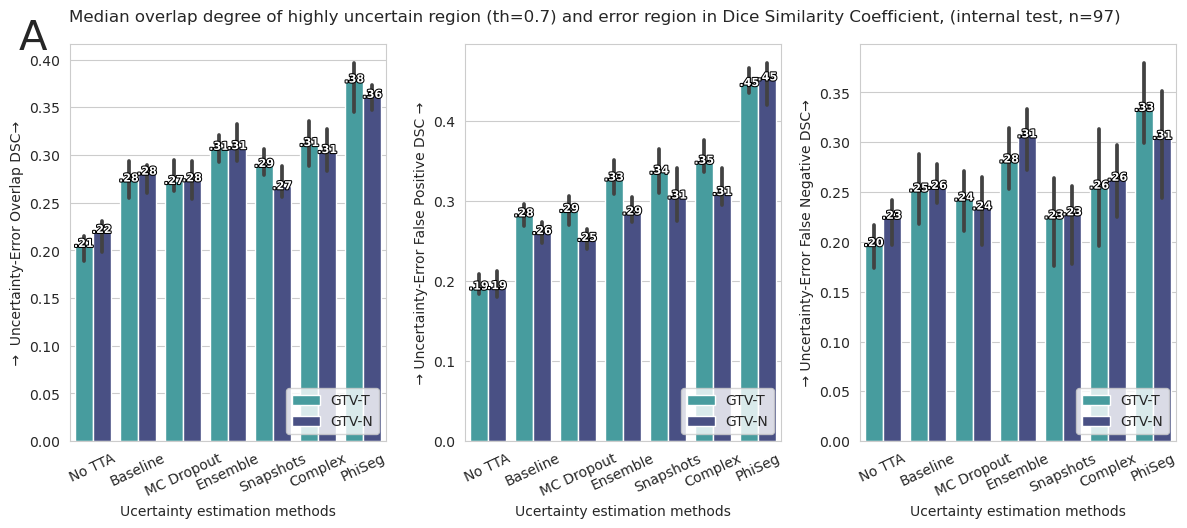

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

def add_median_ci_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}'.lstrip('0'), ha='center', va='center',  color='white', fontweight='bold', fontsize=8)
                       
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=median.get_color()),
            path_effects.Normal(),
        ])

fig.suptitle('Median overlap degree of highly uncertain region (th=0.7) and error region in Dice Similarity Coefficient, (internal test, n=97)', size=12)
fig.text(0.02, 0.9, 'A', size=30)

sns.set_style("whitegrid")
exp= 'UED'
y_value = df_ued_all_internal[exp].astype({exp: float})
sns.barplot(ax = axes[0], x=df_ued_all_internal["Ucertainty estimation methods"], y=y_value,  estimator='median',
             seed=42, n_boot=1000, errorbar=('ci', 95), hue =df_ued_all_internal["GTV"], palette="mako_r").set( ylabel=f' \u2192  Uncertainty-Error Overlap DSC\u2192 ')
exp= 'FPD'
y_value = df_ued_all_internal[exp].astype({exp: float})
sns.barplot(ax = axes[1], x=df_ued_all_internal["Ucertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=1000, errorbar=('ci', 95), hue =df_ued_all_internal["GTV"], palette="mako_r").set( ylabel=' \u2192 Uncertainty-Error False Positive DSC \u2192 ')

exp= 'FND'
y_value = df_ued_all_internal[exp].astype({exp: float})
sns.barplot(ax = axes[2], x=df_ued_all_internal["Ucertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=1000, errorbar=('ci', 95), hue =df_ued_all_internal["GTV"], palette="mako_r").set( ylabel=' \u2192 Uncertainty-Error False Negative DSC\u2192 ')


for p in axes[0].patches:
    text = axes[0].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[1].patches:
    text = axes[1].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[2].patches:
    text = axes[2].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
fig.tight_layout()
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
axes[2].set_xticklabels(axes[1].get_xticklabels(),rotation=25)


[Text(0, 0, 'No TTA'),
 Text(1, 0, 'Baseline'),
 Text(2, 0, 'MC Dropout'),
 Text(3, 0, 'Ensemble'),
 Text(4, 0, 'Snapshots'),
 Text(5, 0, 'Complex'),
 Text(6, 0, 'PhiSeg')]

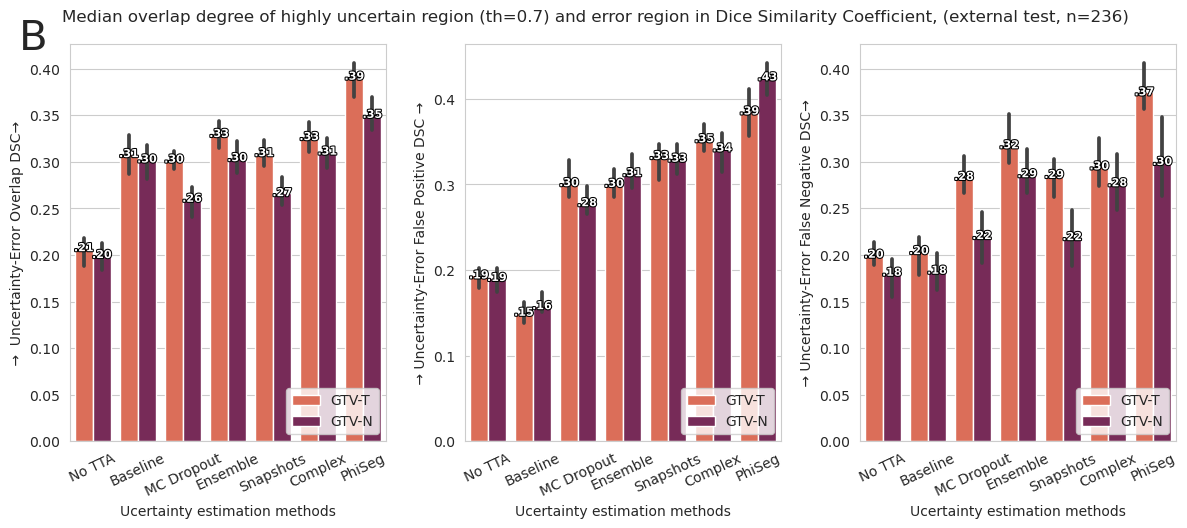

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

fig.suptitle('Median overlap degree of highly uncertain region (th=0.7) and error region in Dice Similarity Coefficient, (external test, n=236)', size=12)

fig.text(0.02, 0.9, 'B', size=30)
sns.set_style("whitegrid")
exp= 'UED'
y_value = df_ued_all_external[exp].astype({exp: float})
sns.barplot(ax = axes[0], x=df_ued_all_external["Ucertainty estimation methods"], y=y_value,  estimator='median',
             seed=42, n_boot=1000, errorbar=('ci', 95), hue =df_ued_all_external["GTV"], palette="rocket_r").set( ylabel=f' \u2192  Uncertainty-Error Overlap DSC\u2192 ')
exp= 'FPD'
y_value = df_ued_all_external[exp].astype({exp: float})
sns.barplot(ax = axes[1], x=df_ued_all_external["Ucertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=1000, errorbar=('ci', 95), hue =df_ued_all_external["GTV"], palette="rocket_r").set( ylabel=' \u2192 Uncertainty-Error False Positive DSC \u2192 ')

exp= 'FND'
y_value = df_ued_all_external[exp].astype({exp: float})
sns.barplot(ax = axes[2], x=df_ued_all_external["Ucertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=1000, errorbar=('ci', 95), hue =df_ued_all_external["GTV"], palette="rocket_r").set( ylabel=' \u2192 Uncertainty-Error False Negative DSC\u2192 ')


for p in axes[0].patches:
    text = axes[0].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[1].patches:
    text = axes[1].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[2].patches:
    text = axes[2].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
fig.tight_layout()
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
axes[2].set_xticklabels(axes[1].get_xticklabels(),rotation=25)


# compare between different methods


In [5]:
def find_best_t(study):
    sum_path = os.path.join(study, 'uregion_summary.json')
    study_name = os.path.basename(study)
    best_GTV_T = 0
    best_GTV_N = 0

    best_GTV_T_s =None
    best_GTV_N_s =None

    with open(sum_path) as file:
        json_dict = json.load(file)
    for key in json_dict.keys():
        cur_t = (json_dict[key]['GTV-T']['UED'])
        cur_n = (json_dict[key]['GTV-N']['UED'])
        
        if best_GTV_T < cur_t:
            best_GTV_T = cur_t
            best_GTV_T_s = key

        if best_GTV_N < cur_n:
            best_GTV_N = cur_n
            best_GTV_N_s = key
    print(f'{study_name} - best GTVT S: {best_GTV_T_s}, UED: {best_GTV_T}, Best GTVN S: {best_GTV_N_s}, UED: {best_GTV_N}')
    bset_t_study = os.path.join(study,  str(best_GTV_T_s), 'GTV-T')
    bset_n_study = os.path.join(study, str(best_GTV_N_s), 'GTV-N')

    return bset_t_study, bset_n_study

In [6]:


## directorys for main internal probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"

studies = [
join(NNUNET_PMAPS,'f0'),
join(NNUNET_PMAPS,'f0_tta'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAP,'f01234_tta')

]
#,join(PH_GAMM_PMAP,'f0_tta')]


groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots',"Complex", 'PhiSeg' ]
for i, study in enumerate(studies):
    gtvt_calib, gtvn_calib  = reconstruct_calib_df_from_json(study)
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    study = study.replace("prob_maps", "u_regions")

    best_t_gtvt_study, best_t_gtvn_study = find_best_t(study)
    gtvt_ued = reconstruct_UED_df_from_json(best_t_gtvt_study)
    gtvn_ued = reconstruct_UED_df_from_json(best_t_gtvn_study)

    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T
    df_cal_t = pd.DataFrame.from_dict(gtvt_calib).T
    df_cal_n = pd.DataFrame.from_dict(gtvn_calib).T
    df_ued_t = pd.DataFrame.from_dict(gtvt_ued).T
    df_ued_n = pd.DataFrame.from_dict(gtvn_ued).T

    dft = pd.concat([df_seg_t,df_cal_t,df_ued_t], axis = 1)
    dfn = pd.concat([df_seg_n,df_cal_n,df_ued_n], axis = 1)
    dft['Ucertainty estimation methods'] = groups[i]
    dfn['Ucertainty estimation methods'] = groups[i]
    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all = dft
        dfn_all = dfn
    else:
        dft_all = pd.concat([dft_all, dft])
        dfn_all = pd.concat([dfn_all, dfn])


all_data_internal = pd.concat([dft_all, dfn_all])
all_data_internal= all_data_internal.reset_index(drop=True)
## directorys for external probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"

studies = [
join(NNUNET_PMAPS,'f0'), #X1
join(NNUNET_PMAPS,'f0_tta'),#X8
join(DROP2_PMAPS,'f0_mc10_tta') #X80
,join(NNUNET_PMAPS,'f01234_tta') #X40
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_PMAPS,'f0_tta_snap') #X40
,join(DROP2_PMAPS,'f01234_mc10_tta_snap') #X2000
,join(PH_PMAP,'f01234_tta') #X40

]
#,join(PH_GAMM_PMAP,'f0_tta')]


groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots',"Complex", 'PhiSeg' ]
for i, study in enumerate(studies):
    gtvt_calib, gtvn_calib  = reconstruct_calib_df_from_json(study)
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    study = study.replace("prob_maps", "u_regions")

    #best_t_gtvt_study, best_t_gtvn_study = find_best_t(study)

    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T
    df_cal_t = pd.DataFrame.from_dict(gtvt_calib).T
    df_cal_n = pd.DataFrame.from_dict(gtvn_calib).T


    dft = pd.concat([df_seg_t,df_cal_t], axis = 1)
    dfn = pd.concat([df_seg_n,df_cal_n], axis = 1)
    dft['Ucertainty estimation methods'] = groups[i]
    dfn['Ucertainty estimation methods'] = groups[i]
    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all = dft
        dfn_all = dfn
    else:
        dft_all = pd.concat([dft_all, dft])
        dfn_all = pd.concat([dfn_all, dfn])


all_data_external = pd.concat([dft_all, dfn_all])
all_data_external= all_data_external.reset_index(drop=True)

f0 - best GTVT S: 1, UED: 0.383, Best GTVN S: 1, UED: 0.359
/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs/f0/1/GTV-T_union/summary.json
/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs/f0/1/GTV-N_union/summary.json
f0_tta - best GTVT S: 1, UED: 0.369, Best GTVN S: 2, UED: 0.344
/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs/f0_tta/1/GTV-T_union/summary.json
/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs/f0_tta/2/GTV-N_union/summary.json
f0_mc10_tta - best GTVT S: 2, UED: 0.345, Best GTVN S: 3, UED: 0.322
/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs/f0_mc10_tta/2/GTV-T_union/

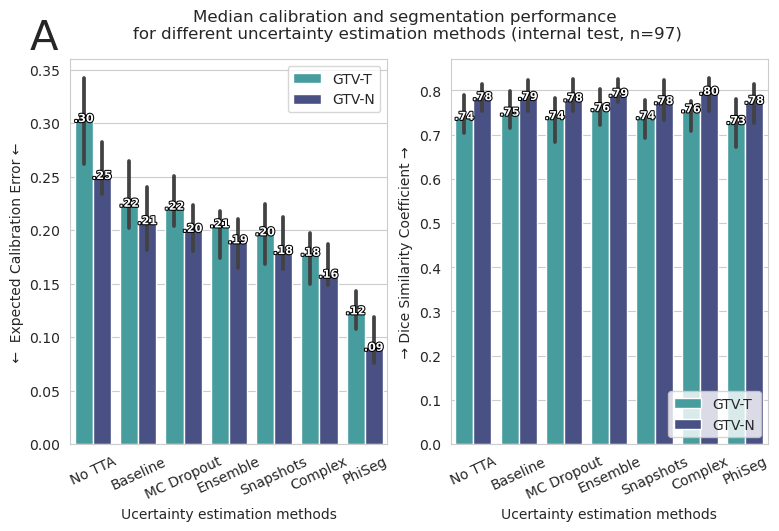

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=False)

def add_median_ci_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}'.lstrip('0'), ha='center', va='center',  color='white', fontweight='bold', fontsize=8)
                       
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=median.get_color()),
            path_effects.Normal(),
        ])

fig.suptitle('Median calibration and segmentation performance \nfor different uncertainty estimation methods (internal test, n=97)', size=12)
fig.text(0.08, 0.9, 'A', size=30)

sns.set_style("whitegrid")
exp= 'Expected Calibration Error'
y_value = all_data_internal[exp].astype({exp: float})
sns.barplot(ax = axes[0], x=all_data_internal["Ucertainty estimation methods"], y=y_value,  estimator='median',
             seed=42, n_boot=1000, errorbar=('ci', 95), hue =all_data_internal["GTV"], palette="mako_r").set( ylabel=f' \u2190  {exp} \u2190 ')
exp= 'DSC'
y_value = all_data_internal[exp].astype({exp: float})
sns.barplot(ax = axes[1], x=all_data_internal["Ucertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=1000, errorbar=('ci', 95), hue =all_data_internal["GTV"], palette="mako_r").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')
#sns.stripplot(ax = axes[2],x=all_data["Ucertainty estimation methods"], y=y_value,  hue =all_data["GTV"], jitter=True,   dodge=True,  palette="mako", alpha=0.1, marker='o', legend=False)


for p in axes[0].patches:
    text = axes[0].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[1].patches:
    text = axes[1].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
axes[0].legend(loc='upper right')
axes[1].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
fig.savefig("figures/fig_2a_bar.png", dpi=300) 
fig.savefig("fig_2a_bar.svg") 

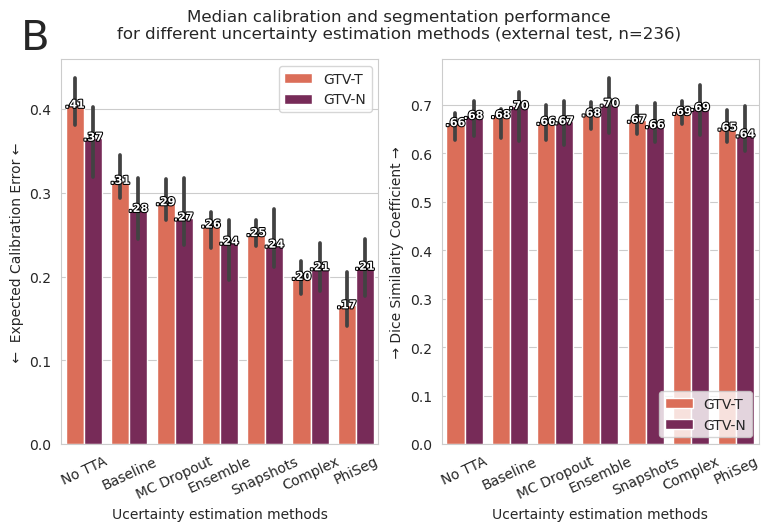

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=False)

fig.suptitle('Median calibration and segmentation performance\nfor different uncertainty estimation methods (external test, n=236)', size=12)
fig.text(0.08, 0.9, 'B', size=30)

sns.set_style("whitegrid")
exp= 'Expected Calibration Error'
y_value = all_data_external[exp].astype({exp: float})
sns.barplot(ax = axes[0], x=all_data_external["Ucertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=1000, errorbar=('ci', 95), hue =all_data_external["GTV"], palette="rocket_r").set( ylabel=f' \u2190  {exp} \u2190 ')
exp= 'DSC'
y_value = all_data_external[exp].astype({exp: float})
sns.barplot(ax = axes[1], x=all_data_external["Ucertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=1000, errorbar=('ci', 95), hue =all_data_external["GTV"], palette="rocket_r").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')

#sns.stripplot(ax = axes[2],x=all_data["Ucertainty estimation methods"], y=y_value,  hue =all_data["GTV"], jitter=True,   dodge=True,  palette="mako", alpha=0.1, marker='o', legend=False)

for p in axes[0].patches:
    text = axes[0].annotate(str(format(np.round(p.get_height(),2), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[1].patches:
    text = axes[1].annotate(str(format(np.round(p.get_height(),2), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
axes[0].legend(loc='upper right')
axes[1].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
plt.show()
fig.savefig("figures/fig_2b_bar.png", dpi=300) 
fig.savefig("figures/fig_2b_bar.svg") 

# False target Correction using uncertainty maps 

In [9]:
## directorys for internal  probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"

studies = [
join(NNUNET_PMAPS,'f0'),
join(NNUNET_PMAPS,'f0_tta'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAP,'f01234_tta')
]
#,join(PH_GAMM_PMAP,'f0_tta')]


groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots', "Complex" ,'PhiSeg']
for i, study in enumerate(studies):
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T

    study = study.replace("prob_maps", "repaired")
    gtvt_seg_correct, gtvn_seg_correct  = reconstruct_seg_df_from_json(study)
    df_seg_t_correct = pd.DataFrame.from_dict(gtvt_seg_correct).T
    df_seg_n_correct = pd.DataFrame.from_dict(gtvn_seg_correct).T
    df_seg_t_correct['GTV'] = 'GTV-T_corrected'
    df_seg_n_correct['GTV'] = 'GTV-N_corrected'

    dft = pd.concat([df_seg_t,df_seg_t_correct], axis = 0)
    dfn = pd.concat([df_seg_n,df_seg_n_correct], axis = 0)

    dft['Ucertainty estimation methods'] = groups[i]
    dfn['Ucertainty estimation methods'] = groups[i]

    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all_correct = dft
        dfn_all_correct = dfn
    else:
        dft_all_correct = pd.concat([dft_all_correct, dft])
        dfn_all_correct = pd.concat([dfn_all_correct, dfn])


all_data_correct_internal = pd.concat([dft_all_correct, dfn_all_correct])
all_data_correct_internal= all_data_correct_internal.reset_index(drop=False)



## directorys for external probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"

studies = [
join(NNUNET_PMAPS,'f0'),
join(NNUNET_PMAPS,'f0_tta'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAP,'f01234_tta')
]
#,join(PH_GAMM_PMAP,'f0_tta')]


groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots', "Complex" ,'PhiSeg']
for i, study in enumerate(studies):
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T

    study = study.replace("prob_maps", "repaired")
    gtvt_seg_correct, gtvn_seg_correct  = reconstruct_seg_df_from_json(study)
    df_seg_t_correct = pd.DataFrame.from_dict(gtvt_seg_correct).T
    df_seg_n_correct = pd.DataFrame.from_dict(gtvn_seg_correct).T
    df_seg_t_correct['GTV'] = 'GTV-T_corrected'
    df_seg_n_correct['GTV'] = 'GTV-N_corrected'

    dft = pd.concat([df_seg_t,df_seg_t_correct], axis = 0)
    dfn = pd.concat([df_seg_n,df_seg_n_correct], axis = 0)

    dft['Ucertainty estimation methods'] = groups[i]
    dfn['Ucertainty estimation methods'] = groups[i]

    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all_correct = dft
        dfn_all_correct = dfn
    else:
        dft_all_correct = pd.concat([dft_all_correct, dft])
        dfn_all_correct = pd.concat([dfn_all_correct, dfn])


all_data_correct_external = pd.concat([dft_all_correct, dfn_all_correct])
all_data_correct_external= all_data_correct_external.reset_index(drop=False)

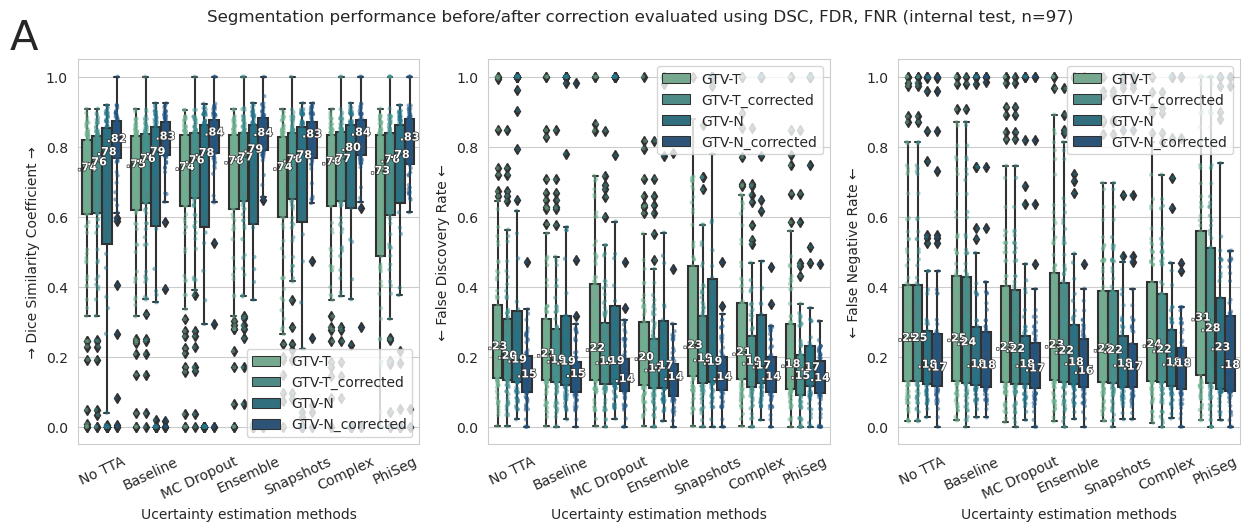

In [10]:

def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = np.round(x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y,2)
        text = ax.text(x, y, f'{value:{fmt}}'.lstrip('0'), ha='center', va='center',  color='white', fontweight='bold', fontsize=8)
                       
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=1, foreground=median.get_color()),
            path_effects.Normal(),
        ])

all_data_correct_internal.replace([np.inf, -np.inf], np.nan, inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
sns.set_style("whitegrid")
fig.suptitle('Segmentation performance before/after correction evaluated using DSC, FDR, FNR (internal test, n=97)' , size=12)
fig.text(0.08, 0.9, 'A', size=30)


exp= 'DSC'
y_value = all_data_correct_internal[exp].astype({exp: float})
sns.stripplot(ax = axes[0],x=all_data_correct_internal["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], jitter=True,   dodge=True,  palette="crest", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[0], x=all_data_correct_internal["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], palette="crest").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')
add_median_labels(axes[0])
#
exp= 'False Discovery Rate'
y_value = all_data_correct_internal[exp].astype({exp: float})
sns.stripplot(ax = axes[1],x=all_data_correct_internal["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], jitter=True,   dodge=True,  palette="crest", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[1], x=all_data_correct_internal["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], palette="crest" ).set( ylabel=' \u2190 False Discovery Rate \u2190 ')
add_median_labels(axes[1])

exp= 'False Negative Rate'
y_value = all_data_correct_internal[exp].astype({exp: float})
sns.stripplot(ax = axes[2],x=all_data_correct_internal["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], jitter=True,   dodge=True,  palette="crest", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[2], x=all_data_correct_internal["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], palette="crest" ).set( ylabel=' \u2190 False Negative Rate \u2190 ')
add_median_labels(axes[2])
#
axes[0].legend(loc='lower right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=25)
plt.show()
fig.savefig("figures/fig_4a_box.png", dpi=300) 
fig.savefig("figures/fig_4a_box.svg") 

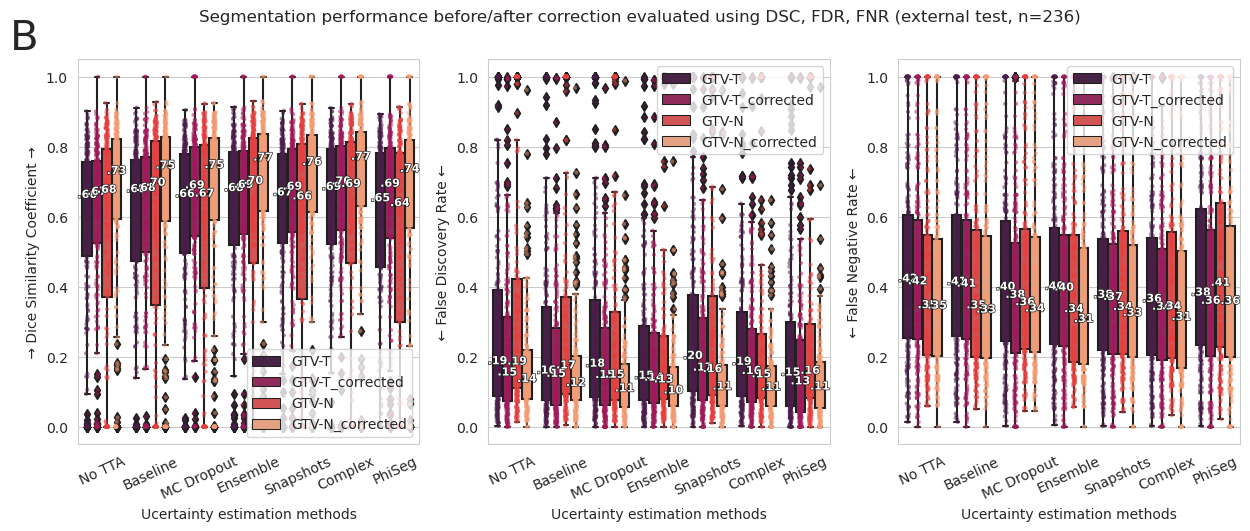

In [11]:


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
sns.set_style("whitegrid")
fig.suptitle('Segmentation performance before/after correction evaluated using DSC, FDR, FNR (external test, n=236)' , size=12)
fig.text(0.08, 0.9, 'B', size=30)

all_data_correct_external.replace([np.inf, -np.inf], np.nan, inplace=True)

exp= 'DSC'
y_value = all_data_correct_external[exp].astype({exp: float})
sns.stripplot(ax = axes[0],x=all_data_correct_external["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], jitter=True,   dodge=True,  palette="rocket", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[0], x=all_data_correct_external["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], palette="rocket").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')
add_median_labels(axes[0])
exp= 'False Discovery Rate'
y_value = all_data_correct_external[exp].astype({exp: float})
sns.stripplot(ax = axes[1],x=all_data_correct_external["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], jitter=True,  dodge=True, palette="rocket",  size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[1], x=all_data_correct_external["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], palette="rocket").set( ylabel=' \u2190 False Discovery Rate \u2190 ')
add_median_labels(axes[1])
exp= 'False Negative Rate'
y_value = all_data_correct_external[exp].astype({exp: float})

sns.stripplot(ax = axes[2],x=all_data_correct_external["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], jitter=True,   dodge=True, palette="rocket",  alpha=0.5, size = 3, marker='o', legend=False)
sns.boxplot(ax = axes[2], x=all_data_correct_external["Ucertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], palette="rocket").set( ylabel=' \u2190 False Negative Rate \u2190 ')

add_median_labels(axes[2])
axes[0].legend(loc='lower right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=25)
plt.show()
fig.savefig("figures/fig_4b_box.png", dpi=300) 
fig.savefig("figures/fig_4b_box.svg") 

### wilcoxon paired test for ensemble study

In [12]:
## directorys for internal  probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"

studies = [
join(NNUNET_PMAPS,'f0'),
join(NNUNET_PMAPS,'f0_tta'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAP,'f01234_tta')
,join(NNUNET_PMAPS,'f0123456789_tta')
]
#,join(PH_GAMM_PMAP,'f0_tta')]


groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots', "Complex" ,'PhiSeg', 'Ensemble10']
for i, study in enumerate(studies):
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T

    study = study.replace("prob_maps", "repaired")
    gtvt_seg_correct, gtvn_seg_correct  = reconstruct_seg_df_from_json(study)
    df_seg_t_correct = pd.DataFrame.from_dict(gtvt_seg_correct).T
    df_seg_n_correct = pd.DataFrame.from_dict(gtvn_seg_correct).T
    df_seg_t_correct['GTV'] = 'GTV-T_corrected'
    df_seg_n_correct['GTV'] = 'GTV-N_corrected'

    dft = pd.concat([df_seg_t,df_seg_t_correct], axis = 0)
    dfn = pd.concat([df_seg_n,df_seg_n_correct], axis = 0)

    dft['Ucertainty estimation methods'] = groups[i]
    dfn['Ucertainty estimation methods'] = groups[i]

    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all_correct = dft
        dfn_all_correct = dfn
    else:
        dft_all_correct = pd.concat([dft_all_correct, dft])
        dfn_all_correct = pd.concat([dfn_all_correct, dfn])


all_data_correct_internal = pd.concat([dft_all_correct, dfn_all_correct])
all_data_correct_internal= all_data_correct_internal.reset_index(drop=False)

from scipy.stats import wilcoxon
test_data = all_data_correct_internal[(all_data_correct_internal["Ucertainty estimation methods"]=='Ensemble10') & ((all_data_correct_internal["GTV"]=="GTV-T") | (all_data_correct_internal["GTV"]=="GTV-T_corrected"))]

def calcualte_test(x, y, method = wilcoxon):
    # method could also be pearsonr
    nas = np.logical_or(np.isnan(x), np.isnan(y)) # remove nan
    return method(x[~nas], y[~nas])

exp= 'DSC'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-T"][exp].astype({exp: float})
print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-T_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")
exp= 'HD95 (mm)'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-T"][exp].astype({exp: float})

print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-T_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")
exp= 'Mean Surface Distance (mm)'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-T"][exp].astype({exp: float})
print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-T_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")


exp= 'DSC'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-N"][exp].astype({exp: float})
print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-N_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")
exp= 'HD95 (mm)'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-N"][exp].astype({exp: float})

print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-N_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")
exp= 'Mean Surface Distance (mm)'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-N"][exp].astype({exp: float})
print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-N_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")

before correction: 0.6860823878718971 0.7606388919915112
after correction: 0.7189857006683261 0.7712423197961936
WilcoxonResult(statistic=0.0, pvalue=0.0006533107814151376)
----------------------
before correction: 12.173829021103606 6.082207001484488
after correction: 7.903478572647291 5.385164807134504
WilcoxonResult(statistic=3.0, pvalue=0.002976637011170516)
----------------------
before correction: 3.396947699492859 1.3393760384712787
after correction: 1.600436486552238 1.2474380581344968
WilcoxonResult(statistic=4.0, pvalue=0.0023294396798343325)
----------------------
before correction: nan nan
after correction: nan nan
WilcoxonResult(statistic=nan, pvalue=nan)
----------------------
before correction: nan nan
after correction: nan nan
WilcoxonResult(statistic=nan, pvalue=nan)
----------------------
before correction: nan nan
after correction: nan nan
WilcoxonResult(statistic=nan, pvalue=nan)
----------------------


# Correlation between uncertainty and segmentation internal data

In [13]:
import SimpleITK as sitk
import numpy as np
from multiprocessing import Pool
from medpy.metric.binary import hd, asd
from scipy.ndimage import binary_erosion

def calcualte_target_entropy(arguments, only_seg_roi=False):
    
    umap_folder , seg_folder,  filename = arguments

    # create an dict for data storage

    seg_path = join(seg_folder, filename) 
    umap_path = join(umap_folder, filename.replace(".nii.gz", ".npz")) 
    pid = filename.replace(".nii.gz", "")
    
    
    seg = sitk.GetArrayFromImage(sitk.ReadImage(seg_path))
    umap = np.load(umap_path)['umap']

    resutl_list = []

    for target in range(1,3):

        entropy_results = {}
        entropy_results['PatientID'] = pid

        if target == 1:
            gtv = 'GTV-T'
            
        elif target == 2:
            gtv = 'GTV-N'

        # create an dict for each GTV
        entropy_results['GTV'] = gtv
    
        mask_seg = seg==target

        target_umap = umap[target]
        mask_umap = target_umap>0.6

        
        roi = mask_seg

        if not only_seg_roi:
            if np.sum(mask_seg) != 0:
                union_roi = (mask_seg + mask_umap)
                union_roi[union_roi>0] = 1
                roi = union_roi
        

        seg_entropy = target_umap * roi
        seg_entropy = seg_entropy[seg_entropy> 0] 



        if np.sum(mask_seg) == 0:
            # no segmentation made for this target (mostly GTV-N)
            entropy_results["Total Entropy"] = np.nan 
            entropy_results["Mean Entropy"] = np.nan 
            entropy_results["Entropy STD"] = np.nan 
            entropy_results["Entropy Volume"] = np.nan 
            entropy_results["Entropy Coefficient of Variation"] = np.nan 
            entropy_results["Logarithm Entropy Coefficient of Variation"] = np.nan 
            # entropy_results["Uncertainty-Segmentation Hausdorff distance"] = np.nan 
            # entropy_results["Uncertainty-Segmentation Mean Surface Distance"] = np.nan 

        else:
            # eros_seg  = binary_erosion(mask_seg, iterations=2).astype(int)
            # seg_line = mask_seg.astype(int) - eros_seg
            # e_hd  = hd(mask_umap, seg_line)
            # e_asd = asd(mask_umap, seg_line)
            entropy_mean = np.mean(seg_entropy) 
            entropy_std = np.std(seg_entropy) 
            entropy_results["Total Entropy"] = np.sum(seg_entropy)
            entropy_results["Mean Entropy"] = entropy_mean
            entropy_results["Entropy STD"] = entropy_std
            entropy_results["Entropy Volume"] = np.sum(roi) 
            entropy_results["Entropy Coefficient of Variation"] = entropy_std / (entropy_mean  + 1e-6) # + 1e-6 to avoid divide by 0
            entropy_results["Logarithm Entropy Coefficient of Variation"] = np.log(entropy_std / (entropy_mean  + 1e-6)) 
            # entropy_results["Uncertainty-Segmentation Hausdorff distance"] = e_hd
            # entropy_results["Uncertainty-Segmentation Mean Surface Distance"] = e_asd

        resutl_list.append(entropy_results)

    return resutl_list

## directorys for internal  probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"


groups = {'No TTA': join(NNUNET_PMAPS,'f0')
          ,'Baseline': join(NNUNET_PMAPS,'f0_tta')
          ,'MC Dropout': join(DROP2_PMAPS,'f0_mc10_tta')
          ,'Ensemble': join(NNUNET_PMAPS,'f01234_tta')
          ,'Snapshots':join(DROP2_PMAPS,'f0_tta_snap')
          ,"Complex":join(DROP2_PMAPS,'f01234_mc10_tta_snap')
          ,'PhiSeg': join(PH_PMAP,'f01234_tta')
          }

Task = 'Complex' #Complex #PhiSeg #External #Baseline #Snapshots
    ## complex
seg_folder = groups[Task]
umap_folder = seg_folder.replace("prob_maps","umaps")

## external
# seg_folder = '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct/f0_mc10_tta' #f01234_mc10_tta'
# umap_folder =  '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/umaps/Task711_NKI_origin/imagesAll_ct_correct/f0_mc10_tta' #f01234_mc10_tta'

seg_files_in = subfiles(seg_folder, suffix=".nii.gz", join=False) 
umaps = [umap_folder] * len(seg_files_in)
segs = [seg_folder] * len(seg_files_in)

p = Pool(128)
entropy_results=  p.map(calcualte_target_entropy, zip(umaps, segs, seg_files_in))
p.close()
p.join()
#=========================================#
entropy_t = []
entropy_n = []
for result in entropy_results:
    entropy_t.append(result[0])
    entropy_n.append(result[1])
entropy_dft = pd.DataFrame(entropy_t)
entropy_dfn = pd.DataFrame(entropy_n)

entropy_df_all = pd.concat([entropy_dft, entropy_dfn], axis=0)
entropy_df_all = entropy_df_all.reset_index(drop=False)

complex_all_data = all_data_internal[all_data_internal["Ucertainty estimation methods"]==Task]
complex_all_data_entropy = pd.merge(complex_all_data, entropy_df_all, how="inner", on=["PatientID", "GTV"])

#====================================#
import scipy 

def calcualte_corr(x, y, method = scipy.stats.spearmanr):
    # method could also be pearsonr
    nas = np.logical_or(np.isnan(x), np.isnan(y)) # remove nan
    r, p = method(x[~nas], y[~nas])
    ps = ''
    print(r,p) 
    if p< 0.05:
        ps = 'p-value<0.05'
    if p< 0.01:
        ps = 'p-value<0.01'    
    if p< 0.001:
        ps = 'p-value<0.001'
    if p< 0.0001:
        ps = 'p-value<0.0001'
    if p> 0.05:
        ps = 'p-value='+str(p)
    return r, ps          
            



/home/jintao/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/jintao/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Entropy inside segmentation to indicate segmentation error

-0.8397275080297582 8.182733279909213e-49
0.551109161606095 1.188875354530708e-14
0.44434023459559163 1.7959602358257012e-09
-0.5853368195085946 9.776486213686235e-17
0.8401105466482537 1.2463142573470245e-48
-0.5472780158094395 2.3578909522678653e-14
-0.41669956909838596 2.3458743425442563e-08
0.5700207121917215 1.095538082698747e-15


(-0.1, 1.1)

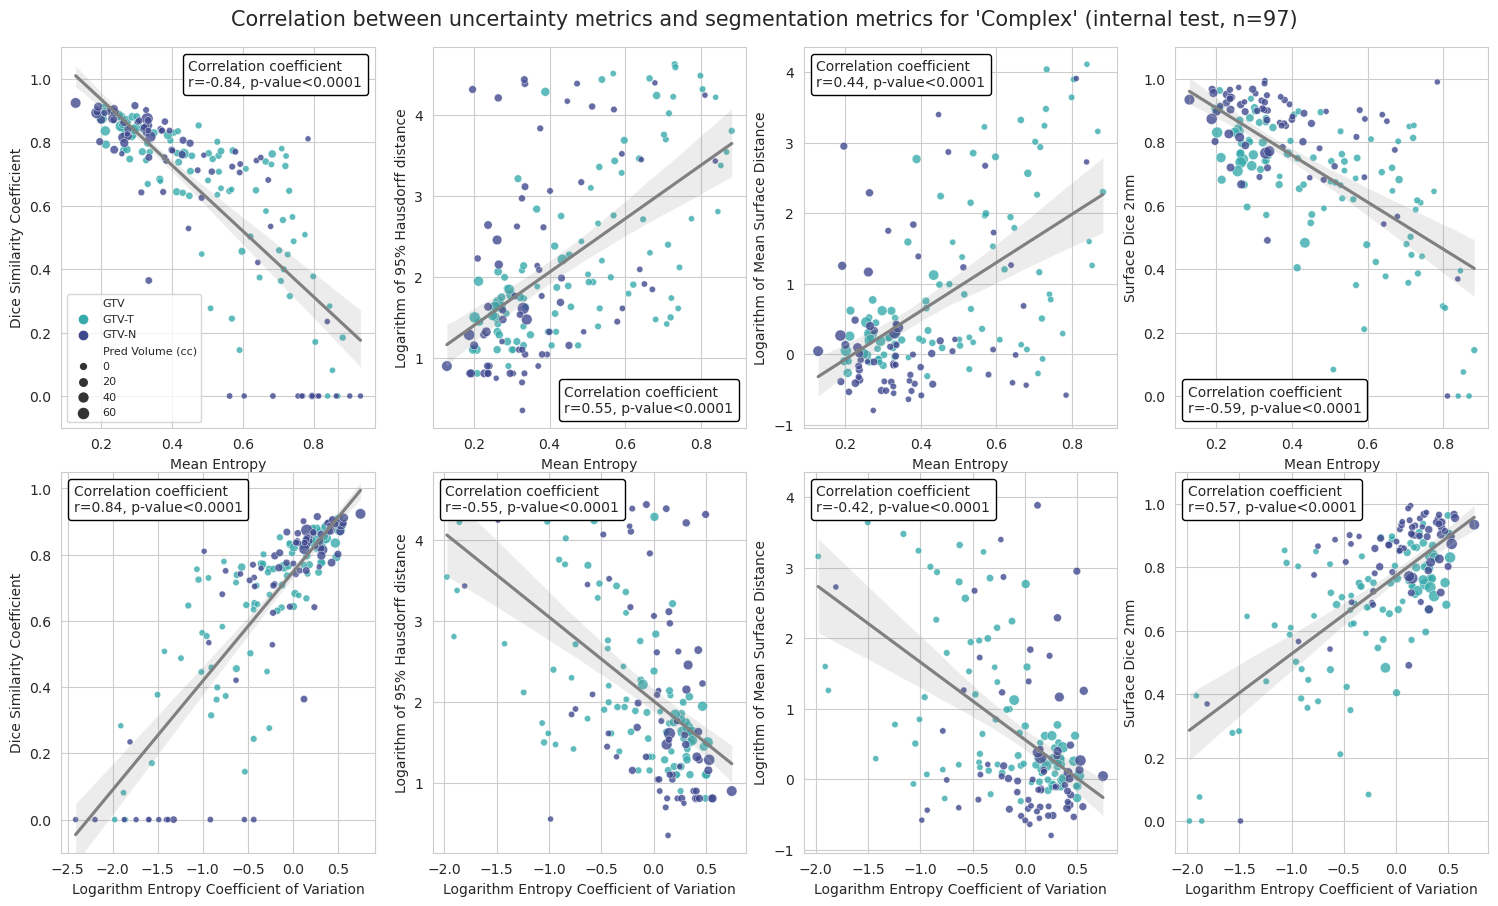

In [14]:
from matplotlib.offsetbox import AnchoredText
from medpy.metric.binary import ravd
complex_all_data_entropy['AVD (cc)'] = np.abs(complex_all_data_entropy['Pred Volume (cc)'] - complex_all_data_entropy['Volume (cc)'] )
complex_all_data_entropy['RAVD (cc)'] = ravd(complex_all_data_entropy['Pred Volume (cc)'] , complex_all_data_entropy['Volume (cc)'] )

complex_all_data_entropy.replace([np.inf, -np.inf], np.nan, inplace=True)

entropy_plot_data = complex_all_data_entropy.astype({"Entropy Coefficient of Variation": float, 
                                                    "DSC": float,
                                                    "Mean Surface Distance (mm)": float,
                                                    "HD95 (mm)": float,
                                                    "Mean Entropy": float,
                                                    "Entropy STD": float, 
                                                    "Entropy Volume" : float,
                                                    "Pred Volume (cc)" : float,
                                                    "Volume (cc)" : float,
                                                    "RAVD (cc)" : float,
                                                    "Surface Dice 2mm" : float
                                                    })#.dropna()



r00,p00 = calcualte_corr(entropy_plot_data['Mean Entropy'], entropy_plot_data['DSC'], method = scipy.stats.spearmanr)
r01,p01 = calcualte_corr(entropy_plot_data['Mean Entropy'], np.log(entropy_plot_data['HD95 (mm)']), method = scipy.stats.spearmanr)
r02,p02 = calcualte_corr(entropy_plot_data['Mean Entropy'], np.log(entropy_plot_data['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
r03,p03 = calcualte_corr(entropy_plot_data['Mean Entropy'], entropy_plot_data['Surface Dice 2mm'], method = scipy.stats.spearmanr)

r10,p10 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], entropy_plot_data['DSC'], method = scipy.stats.spearmanr)
r11,p11 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], np.log(entropy_plot_data['HD95 (mm)']), method = scipy.stats.spearmanr)
r12,p12 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], np.log(entropy_plot_data['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
r13,p13 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], entropy_plot_data['Surface Dice 2mm'], method = scipy.stats.spearmanr)

fig, axes = plt.subplots(2, 4, figsize=(15, 9), sharey=False)
sns.set_style("whitegrid")

fig.suptitle(f'Correlation between uncertainty metrics and segmentation metrics for \'{Task}\' (internal test, n=97)' , size=15)
#fig.text(0.05, 0.95, 'B', size=30)

fig.tight_layout()
########## exp col 0
single_plot_data = entropy_plot_data[['DSC', 'Mean Entropy']].dropna()
y_exp = single_plot_data['DSC']
x_exp = single_plot_data['Mean Entropy']
sns.scatterplot(ax = axes[0][0], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend='auto', alpha=0.8).set( ylabel='Dice Similarity Coefficient')
sns.regplot(ax = axes[0][0], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Dice Similarity Coefficient')
at00 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r00,p00),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',alpha=0.5
                  )
at00.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][0].add_artist(at00)

single_plot_data = entropy_plot_data[['DSC', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = single_plot_data['DSC']
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][0], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8).set( ylabel='Dice Similarity Coefficient')
sns.regplot(ax = axes[1][0], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Dice Similarity Coefficient')
at10 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r10,p10),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',alpha=0.5
                  )
at10.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][0].add_artist(at10)

########## exp col 1
single_plot_data = entropy_plot_data[['HD95 (mm)', 'Mean Entropy']].dropna()
y_exp = np.log(single_plot_data['HD95 (mm)'])
x_exp = single_plot_data['Mean Entropy']
sns.scatterplot(ax = axes[0][1], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend=False, alpha=0.8).set( ylabel='Logarithm of 95% Hausdorff distance')
sns.regplot(ax = axes[0][1], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of 95% Hausdorff distance')
at01 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r01,p01),
                  prop=dict(size=10), frameon=True,
                  loc='lower right', alpha=0.5
                  )
at01.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

axes[0][1].add_artist(at01)
single_plot_data = entropy_plot_data[['HD95 (mm)', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = np.log(single_plot_data['HD95 (mm)'])
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][1], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8).set( ylabel='Logarithm of 95% Hausdorff distance')
sns.regplot(ax = axes[1][1], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of 95% Hausdorff distance')
at11 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r11,p11),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',  alpha=0.5
                  )
at11.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][1].add_artist(at11)

########## exp col 2
single_plot_data = entropy_plot_data[['Mean Surface Distance (mm)', 'Mean Entropy']].dropna()
y_exp = np.log(single_plot_data['Mean Surface Distance (mm)'])
x_exp = single_plot_data['Mean Entropy']

sns.scatterplot(ax = axes[0][2], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8).set( ylabel='Logarithm of Mean Surface Distance')
sns.regplot(ax = axes[0][2], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of Mean Surface Distance')
at02 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r02,p02),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',  alpha=0.5
                  )
at02.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][2].add_artist(at02)

single_plot_data = entropy_plot_data[['Mean Surface Distance (mm)', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = np.log(single_plot_data['Mean Surface Distance (mm)'])
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][2], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8).set( ylabel='Logrithm of Mean Surface Distance')
sns.regplot(ax = axes[1][2], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logrithm of Mean Surface Distance')
at12 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r12,p12),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',  alpha=0.5
                  )
at12.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][2].add_artist(at12)


########## exp col 3
single_plot_data = entropy_plot_data[['Surface Dice 2mm', 'Mean Entropy']].dropna()
y_exp = single_plot_data['Surface Dice 2mm']
x_exp = single_plot_data['Mean Entropy']

sns.scatterplot(ax = axes[0][3], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8)
sns.regplot(ax = axes[0][3], x = x_exp, y = y_exp , scatter =False, color = 'grey')
atr03 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r03,p03),
                  prop=dict(size=10), frameon=True,
                  loc='lower left', alpha=0.5
                  )
atr03.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][3].add_artist(atr03)


single_plot_data = entropy_plot_data[['Surface Dice 2mm', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = single_plot_data['Surface Dice 2mm']
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][3], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8)
sns.regplot(ax = axes[1][3], x = x_exp, y = y_exp , scatter =False, color = 'grey' )
atr13 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r13,p13),
                  prop=dict(size=10), frameon=True,
                  loc='upper left', alpha=0.5
                  )
atr13.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][3].add_artist(atr13)

# new_labels = ["GTVs regression","GTVs regression", "GTVs regression", "GTVs regression"]

ax00handles, ax00labels = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(labels=ax00labels, handles =ax00handles[:-1], loc='lower left', fontsize=8)

#plt.setp(axes[0][0].get_legend().get_texts(), fontsize='8')
axes[0][0].set_ylim(-0.1, 1.1)
axes[1][0].set_ylim(-0.1, 1.05)
#axes[1][0].set_xlim(-3, 1.08)

axes[0][3].set_ylim(-0.1, 1.1)
axes[1][3].set_ylim(-0.1, 1.1)



# correlation between entorpy and segmentation metrics for external data


In [15]:
import SimpleITK as sitk
import numpy as np
from multiprocessing import Pool
from medpy.metric.binary import hd, asd
from scipy.ndimage import binary_erosion


DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"


groups = {'No TTA': join(NNUNET_PMAPS,'f0')
          ,'Baseline': join(NNUNET_PMAPS,'f0_tta')
          ,'MC Dropout': join(DROP2_PMAPS,'f0_mc10_tta')
          ,'Ensemble': join(NNUNET_PMAPS,'f01234_tta')
          ,'Snapshots':join(DROP2_PMAPS,'f0_tta_snap')
          ,"Complex":join(DROP2_PMAPS,'f01234_mc10_tta_snap')
          ,'PhiSeg': join(PH_PMAP,'f01234_tta')
          }

Task = 'Snapshots' #Complex #PhiSeg #External #Baseline #"No TTA" #Ensemble #Snapshots
    ## complex
seg_folder = groups[Task]
umap_folder = seg_folder.replace("prob_maps","umaps")

## external
# seg_folder = '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct/f0_mc10_tta' #f01234_mc10_tta'
# umap_folder =  '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/umaps/Task711_NKI_origin/imagesAll_ct_correct/f0_mc10_tta' #f01234_mc10_tta'

seg_files_in = subfiles(seg_folder, suffix=".nii.gz", join=False) 

umaps = [umap_folder] * len(seg_files_in)
segs = [seg_folder] * len(seg_files_in)

p = Pool(128)
entropy_results_external=  p.map(calcualte_target_entropy, zip(umaps, segs, seg_files_in))
p.close()
p.join()
#=========================================#
entropy_t = []
entropy_n = []
for result in entropy_results_external:
    entropy_t.append(result[0])
    entropy_n.append(result[1])
entropy_dft = pd.DataFrame(entropy_t)
entropy_dfn = pd.DataFrame(entropy_n)

entropy_df_all = pd.concat([entropy_dft, entropy_dfn], axis=0)
entropy_df_all = entropy_df_all.reset_index(drop=False)

complex_all_data = all_data_external[all_data_external["Ucertainty estimation methods"]==Task] # fetch data with the task name
complex_all_data_entropy_external = pd.merge(complex_all_data, entropy_df_all, how="inner", on=["PatientID", "GTV"]) # inner join between entropy and complex data


/home/jintao/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/jintao/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/jintao/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/jintao/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


-0.736993989411859 4.384618209255792e-79
0.5239729717827427 1.0822462944876755e-31
0.4039480150435201 2.621381107678669e-18
-0.561923541514998 3.706792462664138e-37
0.7490705850367296 1.1253195138273932e-82
-0.5181509432992353 8.911129645409103e-31
-0.4028786596764148 3.9204244423507306e-18
0.5687509095191958 4.787031011199867e-38


(-0.1, 1.1)

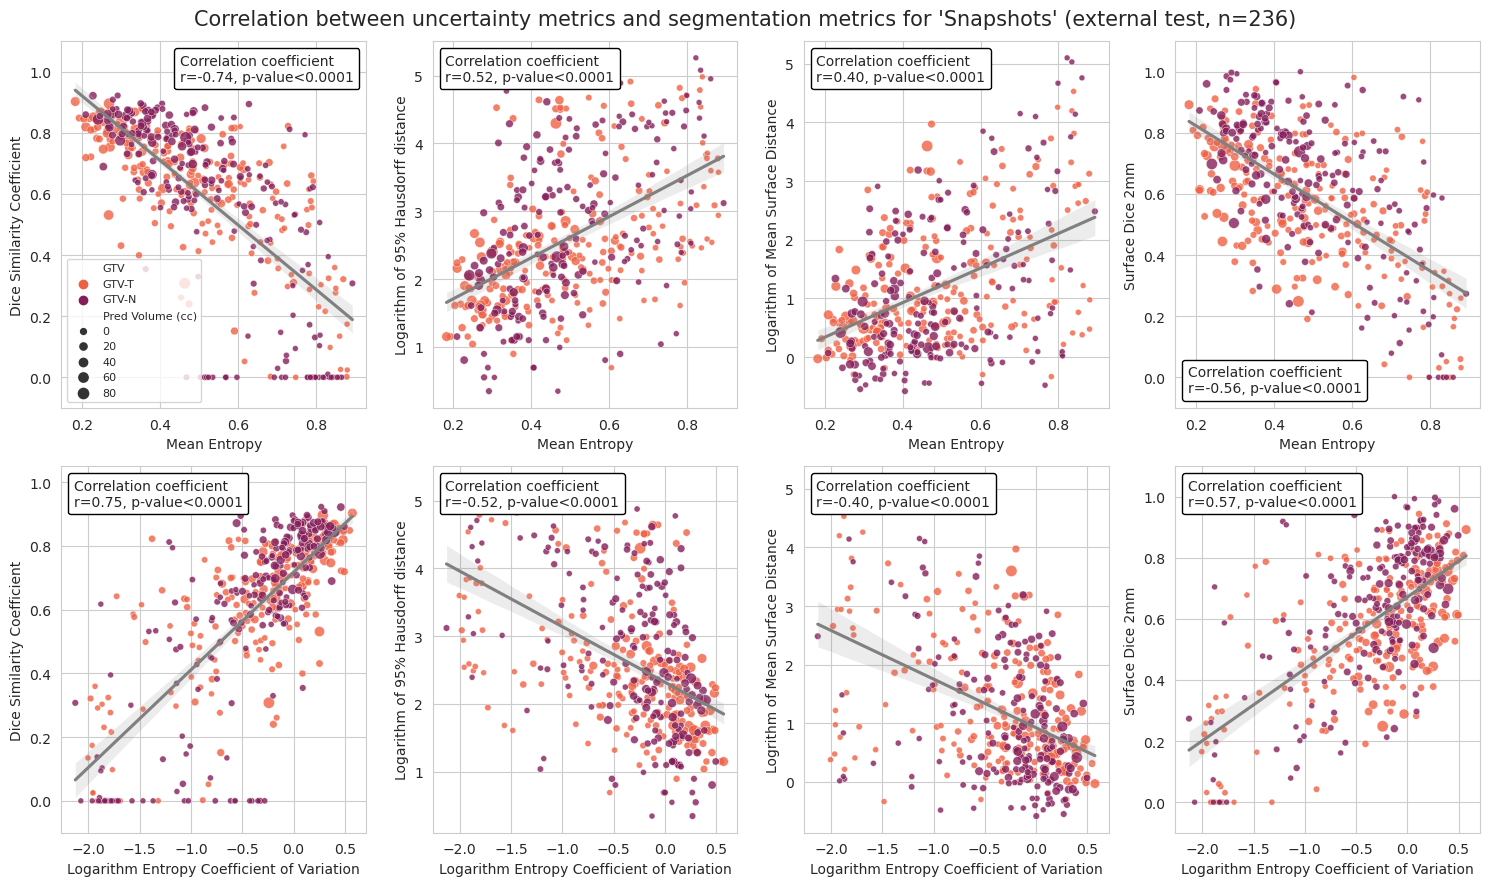

In [16]:
from matplotlib.offsetbox import AnchoredText
from medpy.metric.binary import ravd
complex_all_data_entropy_external['AVD (cc)'] = np.abs(complex_all_data_entropy_external['Pred Volume (cc)'] - complex_all_data_entropy_external['Volume (cc)'] )
complex_all_data_entropy_external['RAVD (cc)'] = ravd(complex_all_data_entropy_external['Pred Volume (cc)'] , complex_all_data_entropy_external['Volume (cc)'] )

complex_all_data_entropy_external.replace([np.inf, -np.inf], np.nan, inplace=True)

entropy_plot_data = complex_all_data_entropy_external.astype({"Entropy Coefficient of Variation": float, 
                                                    "DSC": float,
                                                    "Mean Surface Distance (mm)": float,
                                                    "HD95 (mm)": float,
                                                    "Mean Entropy": float,
                                                    "Entropy STD": float, 
                                                    "Entropy Volume" : float,
                                                    "Pred Volume (cc)" : float,
                                                    "Volume (cc)" : float,
                                                    "RAVD (cc)" : float,
                                                    "Surface Dice 2mm" : float
                                                    })



r00,p00 = calcualte_corr(entropy_plot_data['Mean Entropy'], entropy_plot_data['DSC'], method = scipy.stats.spearmanr)
r01,p01 = calcualte_corr(entropy_plot_data['Mean Entropy'], np.log(entropy_plot_data['HD95 (mm)']), method = scipy.stats.spearmanr)
r02,p02 = calcualte_corr(entropy_plot_data['Mean Entropy'], np.log(entropy_plot_data['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
r03,p03 = calcualte_corr(entropy_plot_data['Mean Entropy'], entropy_plot_data['Surface Dice 2mm'], method = scipy.stats.spearmanr)

r10,p10 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], entropy_plot_data['DSC'], method = scipy.stats.spearmanr)
r11,p11 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], np.log(entropy_plot_data['HD95 (mm)']), method = scipy.stats.spearmanr)
r12,p12 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], np.log(entropy_plot_data['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
r13,p13 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], entropy_plot_data['Surface Dice 2mm'], method = scipy.stats.spearmanr)


fig, axes = plt.subplots(2, 4, figsize=(15, 9), sharey=False)
sns.set_style("whitegrid")

fig.suptitle(f'Correlation between uncertainty metrics and segmentation metrics for \'{Task}\' (external test, n=236)' , size=15)
#fig.text(0.05, 0.95, 'B', size=30)

fig.tight_layout()
########## exp col 0
single_plot_data = entropy_plot_data[['DSC', 'Mean Entropy']].dropna()
y_exp = single_plot_data['DSC']
x_exp = single_plot_data['Mean Entropy']
sns.scatterplot(ax = axes[0][0], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="rocket_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend='auto', alpha=0.8).set( ylabel='Dice Similarity Coefficient')
sns.regplot(ax = axes[0][0], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Dice Similarity Coefficient')
at00 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r00,p00),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
at00.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][0].add_artist(at00)

single_plot_data = entropy_plot_data[['DSC', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = single_plot_data['DSC']
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][0], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="rocket_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8).set( ylabel='Dice Similarity Coefficient')
sns.regplot(ax = axes[1][0], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Dice Similarity Coefficient')
at10 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r10,p10),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at10.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][0].add_artist(at10)

########## exp col 1
single_plot_data = entropy_plot_data[['HD95 (mm)', 'Mean Entropy']].dropna()
y_exp = np.log(single_plot_data['HD95 (mm)'])
x_exp = single_plot_data['Mean Entropy']
sns.scatterplot(ax = axes[0][1], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="rocket_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend=False, alpha=0.8).set( ylabel='Logarithm of 95% Hausdorff distance')
sns.regplot(ax = axes[0][1], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of 95% Hausdorff distance')
at01 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r01,p01),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at01.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

axes[0][1].add_artist(at01)
single_plot_data = entropy_plot_data[['HD95 (mm)', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = np.log(single_plot_data['HD95 (mm)'])
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][1], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="rocket_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8).set( ylabel='Logarithm of 95% Hausdorff distance')
sns.regplot(ax = axes[1][1], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of 95% Hausdorff distance')
at11 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r11,p11),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at11.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][1].add_artist(at11)

########## exp col 2
single_plot_data = entropy_plot_data[['Mean Surface Distance (mm)', 'Mean Entropy']].dropna()
y_exp = np.log(single_plot_data['Mean Surface Distance (mm)'])
x_exp = single_plot_data['Mean Entropy']

sns.scatterplot(ax = axes[0][2], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="rocket_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8).set( ylabel='Logarithm of Mean Surface Distance')
sns.regplot(ax = axes[0][2], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of Mean Surface Distance')
at02 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r02,p02),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at02.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][2].add_artist(at02)

single_plot_data = entropy_plot_data[['Mean Surface Distance (mm)', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = np.log(single_plot_data['Mean Surface Distance (mm)'])
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][2], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="rocket_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8).set( ylabel='Logrithm of Mean Surface Distance')
sns.regplot(ax = axes[1][2], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logrithm of Mean Surface Distance')
at12 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r12,p12),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at12.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][2].add_artist(at12)


########## exp col 3
single_plot_data = entropy_plot_data[['Surface Dice 2mm', 'Mean Entropy']].dropna()
y_exp = single_plot_data['Surface Dice 2mm']
x_exp = single_plot_data['Mean Entropy']

sns.scatterplot(ax = axes[0][3], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="rocket_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8)
sns.regplot(ax = axes[0][3], x = x_exp, y = y_exp , scatter =False, color = 'grey')
atr03 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r03,p03),
                  prop=dict(size=10), frameon=True,
                  loc='lower left',
                  )
atr03.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][3].add_artist(atr03)


single_plot_data = entropy_plot_data[['Surface Dice 2mm', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = single_plot_data['Surface Dice 2mm']
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][3], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="rocket_r",  
                size = entropy_plot_data['Pred Volume (cc)'], legend= False, alpha=0.8)
sns.regplot(ax = axes[1][3], x = x_exp, y = y_exp , scatter =False, color = 'grey')
atr13 = AnchoredText("Correlation coefficient\nr=%.2f, %s"%(r13,p13),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
atr13.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][3].add_artist(atr13)

# new_labels = ["GTVs regression","GTVs regression", "GTVs regression", "GTVs regression"]

ax00handles, ax00labels = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(labels=ax00labels, handles =ax00handles[:-1], loc='lower left', fontsize=8)
fig.tight_layout()
#plt.setp(axes[0][0].get_legend().get_texts(), fontsize='8')
axes[0][0].set_ylim(-0.1, 1.1)
axes[1][0].set_ylim(-0.1, 1.05)
#axes[1][0].set_xlim(-3, 1.08)

axes[0][3].set_ylim(-0.1, 1.1)
axes[1][3].set_ylim(-0.1, 1.1)
